In [1]:
import sys
sys.path.append("../Algorithms/")

In [2]:
import numpy as np 
from numpy import linalg as la
from numpy.random import uniform
from scipy.sparse import random
from matplotlib import pyplot as plt 
from itertools import product
# from sklearn.decomposition import PCA 
# from sklearn import datasets
from time import time

from random_svd import randomized_svd

Motivation: 

One of the useful characteristics of the Randomized SVD algorithm is that the trade-off between temporal efficiency and accuracy is customizable. The parameters $k$ (which specifies desired rank), proportion (which specifies how much of the original matrix to use in computation), r (which specifies how many subspace iterations to perform if using subspace iteration in place of the QR algorithm), and q (which specifies how many power iterations to perform), can all be adjusted to increase the accuracy of the SVD approximation. However, increasing the accuracy using these parameters also leads to increased temporal complexity and runtimes, since they involve either more computational steps or larger matrices. The goal here is to analyze how each of these parameters affects runtime and relative error, and to provide a rudimentary guideline for choosing these parameters. 

In [3]:
def find_optimal_k(A, k_vals, r=2, q=0, range_method="qr", proportion=None, plot=True, plot_title=None, save_title=None):

    runtimes = np.zeros_like(k_vals, dtype=float)
    errors = np.zeros_like(k_vals, dtype=float)

    for i, k in enumerate(k_vals):
        # timed computation of randomized svd
        start = time()
        U, S, Vh = randomized_svd(A=A, k=k, r=r, q=q, range_method=range_method, proportion=proportion)
        end = time()

        # compute relative error of the approximation of A 
        A_approx = U @ np.diag(S) @ Vh
        rel_error = la.norm(A - A_approx, ord=2) / la.norm(A, ord=2)

        # save runtime and relative error 
        runtimes[i] = end - start 
        errors[i] = rel_error 
    
    if plot:
        # plot results 
        plt.figure(figsize=(8, 4))
        fig, ax1 = plt.subplots()
        fig.set_figheight(3)
        fig.set_figwidth(7)

        l1, = ax1.plot(k_vals, errors, c="tab:blue")
        ax1.set_xlabel(r"Target Rank $k$")
        ax1.set_ylabel("Relative Error")

        ax2 = ax1.twinx()
        l2, = ax2.plot(k_vals, runtimes, c="tab:orange", linestyle="--")
        ax2.set_ylabel("Computation Time")

        # ax1.legend([l1, l2], ["Relative Error", "Computation Time"])
        ax1.legend([l1, l2], ["Relative Error", "Computation Time"], loc="upper center", bbox_to_anchor=(0.5, -0.25), ncol=2)
        if plot_title is None: plt.title("Runtime and Accuracy vs. Target Rank")
        else: plt.title(plot_title)

        if save_title is not None:
            plt.savefig(save_title, dpi=300, bbox_inches="tight")

        plt.show()
    
    return runtimes, errors

1. Test optimal parameters for dense matrices.

We will test for optimal parameters on dense, uniformly distributed matrices with dimension 5000x5000. These dimensions are a somewhat arbitrary choice, and the same analysis could be performed on any size of matrix to test for suitable parameters. We chose these dimensions because a direct computation of the SVD using numpy.linalg.svd() on a dense matrix of this size takes between 45-60 seconds, which we say is unreasonable.

<Figure size 800x400 with 0 Axes>

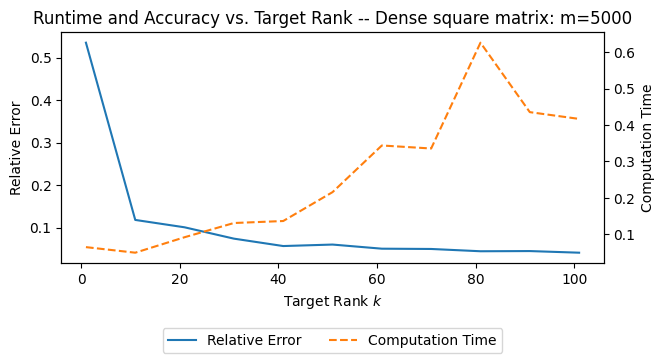

In [4]:
m = 5000
A = uniform(size=(m, m))
k_vals = np.arange(1, 102, 10)

runtimes, errors = find_optimal_k(A, k_vals, 
                                  plot_title="Runtime and Accuracy vs. Target Rank -- Dense square matrix: m=5000",
                                  save_title="dense_matrix_computations.png")

2. Test optimal parameters for tall (skinny) matrices -- these are relevant for application like PCA, where we might have a dataset with a very large number of samples and relatively fewer features. We will use a uniformly sample matrix of dimensions 5000x100 (again, this is somewhat arbitrary, but we are simply choosing something that makes the standard SVD take a long time).

<Figure size 800x400 with 0 Axes>

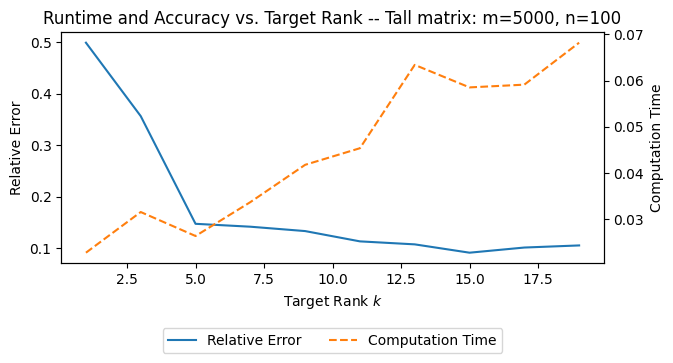

In [5]:
m = 5000
n = 100
A = uniform(size=(m, m))

k_vals = np.arange(1, 21, 2)

runtimes, errors = find_optimal_k(A, k_vals, 
                                  plot_title="Runtime and Accuracy vs. Target Rank -- Tall matrix: m=5000, n=100",
                                  save_title="tall_matrix_computations.png")

In [63]:
k_vals = np.arange(1, 21, 2)
print(k_vals)

[ 1  3  5  7  9 11 13 15 17 19]


3. Test optimal parameters for sparse matrices.

<Figure size 800x400 with 0 Axes>

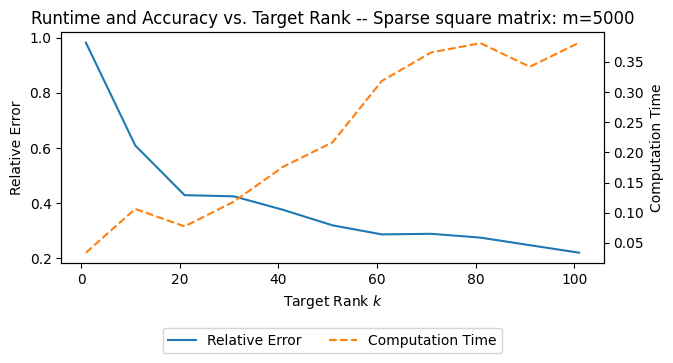

In [4]:
m = 5000
A = random(m=m, n=m, density=0.1, format='csr').toarray()
k_vals = np.arange(1, 102, 10)

runtimes, errors = find_optimal_k(A, k_vals, 
                                  plot_title="Runtime and Accuracy vs. Target Rank -- Sparse square matrix: m=5000",
                                  save_title="sparse_matrix_computations.png")

In [6]:
def grid_search(A, tol=0.1, ratio=None):
    ''' Given an input matrix A and a desired level of accuracy (measured in relative error),
        determine the optimal hyperparameters for randomized SVD:
    '''

    k_vals = [10, 30, 50, 80, 100]
    range_method_vals = ['qr', "subspace_iter"]
    proportion_vals = [.1, .3, .5, .8]
    rq_vals = [1, 2]

    param_combos = list(product(k_vals, range_method_vals, proportion_vals, rq_vals))
    rel_errors = np.zeros(len(param_combos), dtype=float)
    runtimes = np.zeros(len(param_combos), dtype=float)

    for i, params in enumerate(param_combos):
        # print(i, params)
        k, range_method, proportion, rq = params 
        if range_method == "qr":
            # use power iteration + Gram Schmidt (no subspace iteration)
            start = time()
            U, S, Vh = randomized_svd(A = A, k=k, r=0, q=rq, range_method=range_method, proportion=proportion)
            end = time()
        elif range_method == "subspace_iter":
            # use subspace iteration (no power iteration)
            start = time()
            U, S, Vh = randomized_svd(A = A, k=k, r=rq, q=0, range_method=range_method, proportion=proportion)
            end = time()
        else: raise ValueError("Unknown value for range_method")

        # reconstruct A and compute relative error, runtime
        A_approx = U @ np.diag(S) @ Vh 
        rel_error = la.norm(A_approx - A) / la.norm(A)
        rel_errors[i] = rel_error
        runtimes[i] = end - start
    
    if tol is not None:
        # find the set of parameters with lowest runtime that satisfies relative error less than tol
        mask = rel_errors > tol
        if np.sum(mask) == len(param_combos):
            return None 
        temp_runtimes = runtimes.copy()
        temp_runtimes[mask] = np.inf
        min_index = np.argmin(temp_runtimes)
        opt_time = runtimes[min_index]
        opt_error = rel_errors[min_index]
        opt_params = param_combos[min_index]
    
    elif ratio is not None:
        # compute a weighted score for relative error and runtime, find the minimum score
        scores = ratio * rel_error + (1. - ratio) * runtimes
        opt_index = np.argmin(scores)
        opt_time = runtimes[opt_index]
        opt_error = rel_errors[opt_index]
        opt_params = param_combos[opt_index]

    return opt_params, opt_error, opt_time
    

In [7]:
# find optimal parameters for a 1000x1000 dense matrix, with relative error tolerance 0.1
m = 1000
A = uniform(size=(m, m))
tol = 0.1

opt_params, opt_error, opt_time = grid_search(A, tol=None, ratio=0.85)
print(f"Optimal Paramteers: {opt_params}")
print(f"Optimal Relative Error: {opt_error}")
print(f"Optimal Runtime: {opt_error}")

Optimal Paramteers: (100, 'qr', 0.1, 1)
Optimal Relative Error: 0.43081836727096307
Optimal Runtime: 0.43081836727096307


In [41]:
print(opt_params)

(100, 'qr', 0.8, 1)


In [15]:
k_vals = [10, 30, 50, 80, 100]
range_method = ['qr_method', "subspace_iter"]
proportion = [.1, .3, .5, .8]
rq_vals = [0, 1, 2]

stuff = list(product(k_vals, range_method, proportion, rq_vals))
print(stuff)
print(len(stuff))
    

[(10, 'qr_method', 0.1, 0), (10, 'qr_method', 0.1, 1), (10, 'qr_method', 0.1, 2), (10, 'qr_method', 0.3, 0), (10, 'qr_method', 0.3, 1), (10, 'qr_method', 0.3, 2), (10, 'qr_method', 0.5, 0), (10, 'qr_method', 0.5, 1), (10, 'qr_method', 0.5, 2), (10, 'qr_method', 0.8, 0), (10, 'qr_method', 0.8, 1), (10, 'qr_method', 0.8, 2), (10, 'subspace_iter', 0.1, 0), (10, 'subspace_iter', 0.1, 1), (10, 'subspace_iter', 0.1, 2), (10, 'subspace_iter', 0.3, 0), (10, 'subspace_iter', 0.3, 1), (10, 'subspace_iter', 0.3, 2), (10, 'subspace_iter', 0.5, 0), (10, 'subspace_iter', 0.5, 1), (10, 'subspace_iter', 0.5, 2), (10, 'subspace_iter', 0.8, 0), (10, 'subspace_iter', 0.8, 1), (10, 'subspace_iter', 0.8, 2), (30, 'qr_method', 0.1, 0), (30, 'qr_method', 0.1, 1), (30, 'qr_method', 0.1, 2), (30, 'qr_method', 0.3, 0), (30, 'qr_method', 0.3, 1), (30, 'qr_method', 0.3, 2), (30, 'qr_method', 0.5, 0), (30, 'qr_method', 0.5, 1), (30, 'qr_method', 0.5, 2), (30, 'qr_method', 0.8, 0), (30, 'qr_method', 0.8, 1), (30, '